In [1]:
import os
import json
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image, ImageOps

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")  
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [ ]:
class ClimbingHoldDataset(Dataset):
    """
    Loads climbing holds from COCO-style annotations.
    Returns:
        image: Tensor [3, 224, 224]
        type: int index
        orientation: int index
    """

    def __init__(self, annotations_dir, images_dir, transform=None, output_size=(224, 224)):
        self.annotations_dir = annotations_dir
        self.images_dir = images_dir
        self.transform = transform
        self.output_size = output_size

        self.types_list = ['Jug', 'Sloper', 'Crimp', 'Jib', 'Pinch', 'Pocket', 'Edge']
        self.orientations_list = ['Up', 'Down', 'Side', 'UpAng', 'DownAng']

        self.holds = []

        for file in os.listdir(annotations_dir):
            if not file.endswith(".json"):
                continue

            json_path = os.path.join(annotations_dir, file)
            with open(json_path, "r") as f:
                data = json.load(f)

            images = {img["id"]: img["file_name"] for img in data.get("images", [])}
            annotations = data.get("annotations", [])

            for ann in annotations:
                image_id = ann.get("image_id")
                file_name = images.get(image_id)
                bbox = ann.get("bbox")
                attrs = ann.get("attributes", {}) or {}

                type_label = attrs.get("Type")
                orient_label = attrs.get("Orientation")

                if file_name is None or bbox is None:
                    continue
                if type_label not in self.types_list:
                    continue
                if orient_label not in self.orientations_list:
                    continue

                img_path = os.path.join(images_dir, file_name)
                if not os.path.exists(img_path):
                    continue

                self.holds.append({
                    "image_id": file_name,
                    "bbox": bbox,
                    "type": type_label,
                    "orientation": orient_label,
                })

        print(f"Loaded {len(self.holds)} valid holds with type + orientation.")

    def __len__(self):
        return len(self.holds)

    def __getitem__(self, idx):
        hold = self.holds[idx]

        img_path = os.path.join(self.images_dir, hold["image_id"])
        img = Image.open(img_path).convert("RGB")
        img = ImageOps.exif_transpose(img)

        x, y, w, h = hold["bbox"]
        x, y, w, h = map(int, (x, y, w, h))
        img = img.crop((x, y, x + w, y + h))
        img = img.resize(self.output_size)

        if self.transform:
            img = self.transform(img)

        type_idx = self.types_list.index(hold["type"])
        orient_idx = self.orientations_list.index(hold["orientation"])

        return {
            "image": img,
            "type": type_idx,
            "orientation": orient_idx,
        }


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

annotations_dir = "data/annotations"
images_dir = "data/images"

dataset = ClimbingHoldDataset(
    annotations_dir=annotations_dir,
    images_dir=images_dir,
    transform=transform,
)

print("Total samples:", len(dataset))


type_labels_np = np.array([dataset[i]["type"] for i in range(len(dataset))])
orient_labels_np = np.array([dataset[i]["orientation"] for i in range(len(dataset))])

print("type_labels_np shape:", type_labels_np.shape)
print("orient_labels_np shape:", orient_labels_np.shape)

print("Type distribution:", Counter(type_labels_np))
print("Orientation distribution:", Counter(orient_labels_np))

num_types = len(dataset.types_list)
num_orients = len(dataset.orientations_list)


train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Loaded 1605 valid holds with type + orientation.
Total samples: 1605
type_labels_np shape: (1605,)
orient_labels_np shape: (1605,)
Type distribution: Counter({np.int64(0): 593, np.int64(3): 307, np.int64(1): 232, np.int64(2): 202, np.int64(4): 132, np.int64(6): 127, np.int64(5): 12})
Orientation distribution: Counter({np.int64(0): 766, np.int64(3): 533, np.int64(2): 211, np.int64(4): 54, np.int64(1): 41})
Train size: 1284, Val size: 321


In [9]:
from torchvision.models import ResNet18_Weights

class TwoHeadResNet18(nn.Module):
    def __init__(self, num_types=7, num_orientations=5, pretrained=True):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = models.resnet18(weights=weights)

        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()  

        self.backbone = backbone

        self.type_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_types)
        )
        self.orientation_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_orientations)
        )

    def forward(self, x):
        feats = self.backbone(x)
        type_logits = self.type_head(feats)
        orientation_logits = self.orientation_head(feats)
        return type_logits, orientation_logits


model = TwoHeadResNet18(
    num_types=num_types,
    num_orientations=num_orients,
    pretrained=False, 
).to(device)

for param in model.parameters():
    param.requires_grad = True

criterion_type = nn.CrossEntropyLoss()
criterion_orientation = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [5]:
num_epochs = 10 

train_losses = []
val_losses = []

train_acc_type = []
train_acc_orientation = []

val_acc_type = []
val_acc_orientation = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_type = 0
    correct_orientation = 0
    total = 0

    for batch in train_loader:
        images = batch["image"].to(device)
        labels_type = batch["type"].to(device)
        labels_orientation = batch["orientation"].to(device)

        optimizer.zero_grad()
        out_type, out_orientation = model(images)

        loss_type = criterion_type(out_type, labels_type)
        loss_orientation = criterion_orientation(out_orientation, labels_orientation)

        loss = loss_type + loss_orientation
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        total += images.size(0)

        preds_type = out_type.argmax(dim=1)
        preds_orientation = out_orientation.argmax(dim=1)

        correct_type += (preds_type == labels_type).sum().item()
        correct_orientation += (preds_orientation == labels_orientation).sum().item()

    epoch_train_loss = running_loss / total
    epoch_train_acc_type = correct_type / total
    epoch_train_acc_orientation = correct_orientation / total

    train_losses.append(epoch_train_loss)
    train_acc_type.append(epoch_train_acc_type)
    train_acc_orientation.append(epoch_train_acc_orientation)

    model.eval()
    val_running_loss = 0.0
    val_correct_type = 0
    val_correct_orientation = 0
    val_total = 0

    all_val_type_true = []
    all_val_type_pred = []
    all_val_orient_true = []
    all_val_orient_pred = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            labels_type = batch["type"].to(device)
            labels_orientation = batch["orientation"].to(device)

            out_type, out_orientation = model(images)

            loss_type = criterion_type(out_type, labels_type)
            loss_orientation = criterion_orientation(out_orientation, labels_orientation)

            loss = loss_type + loss_orientation
            val_running_loss += loss.item() * images.size(0)

            preds_type = out_type.argmax(dim=1)
            preds_orientation = out_orientation.argmax(dim=1)

            val_correct_type += (preds_type == labels_type).sum().item()
            val_correct_orientation += (preds_orientation == labels_orientation).sum().item()
            val_total += images.size(0)

            all_val_type_true.append(labels_type.cpu().numpy())
            all_val_type_pred.append(preds_type.cpu().numpy())
            all_val_orient_true.append(labels_orientation.cpu().numpy())
            all_val_orient_pred.append(preds_orientation.cpu().numpy())

    epoch_val_loss = val_running_loss / val_total
    epoch_val_acc_type = val_correct_type / val_total
    epoch_val_acc_orientation = val_correct_orientation / val_total

    val_losses.append(epoch_val_loss)
    val_acc_type.append(epoch_val_acc_type)
    val_acc_orientation.append(epoch_val_acc_orientation)

    y_true_type_val = np.concatenate(all_val_type_true)
    y_pred_type_val = np.concatenate(all_val_type_pred)
    y_true_orient_val = np.concatenate(all_val_orient_true)
    y_pred_orient_val = np.concatenate(all_val_orient_pred)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train loss: {epoch_train_loss:.4f} | Val loss: {epoch_val_loss:.4f} | "
        f"Train acc [Type:{epoch_train_acc_type:.3f}, "
        f"Orient:{epoch_train_acc_orientation:.3f}] | "
        f"Val acc [Type:{epoch_val_acc_type:.3f}, "
        f"Orient:{epoch_val_acc_orientation:.3f}]"
    )


Epoch 1/10 | Train loss: 2.9830 | Val loss: 2.8965 | Train acc [Type:0.360, Orient:0.453] | Val acc [Type:0.361, Orient:0.470]
Epoch 2/10 | Train loss: 2.7150 | Val loss: 2.7499 | Train acc [Type:0.424, Orient:0.497] | Val acc [Type:0.427, Orient:0.480]
Epoch 3/10 | Train loss: 2.6567 | Val loss: 2.6704 | Train acc [Type:0.445, Orient:0.512] | Val acc [Type:0.442, Orient:0.495]
Epoch 4/10 | Train loss: 2.5822 | Val loss: 2.5908 | Train acc [Type:0.465, Orient:0.529] | Val acc [Type:0.495, Orient:0.514]
Epoch 5/10 | Train loss: 2.5149 | Val loss: 2.6158 | Train acc [Type:0.475, Orient:0.541] | Val acc [Type:0.449, Orient:0.536]
Epoch 6/10 | Train loss: 2.4886 | Val loss: 2.6469 | Train acc [Type:0.486, Orient:0.540] | Val acc [Type:0.486, Orient:0.526]
Epoch 7/10 | Train loss: 2.4044 | Val loss: 2.5603 | Train acc [Type:0.505, Orient:0.551] | Val acc [Type:0.449, Orient:0.558]
Epoch 8/10 | Train loss: 2.3914 | Val loss: 2.5401 | Train acc [Type:0.498, Orient:0.579] | Val acc [Type:0.523

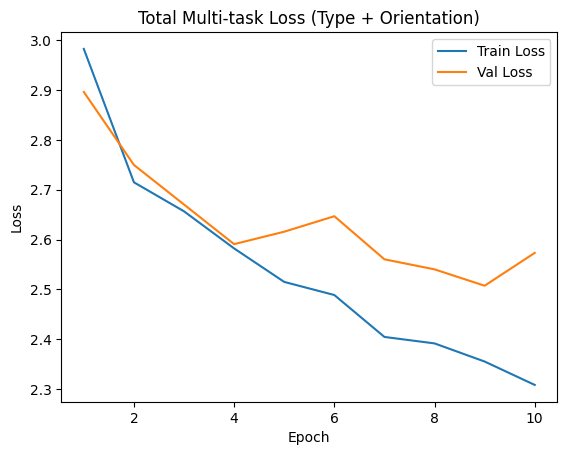

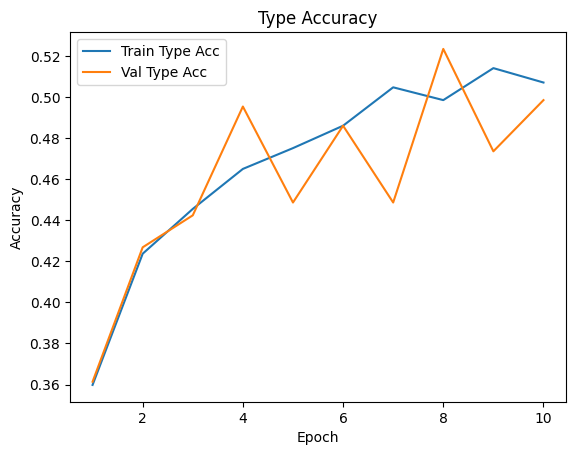

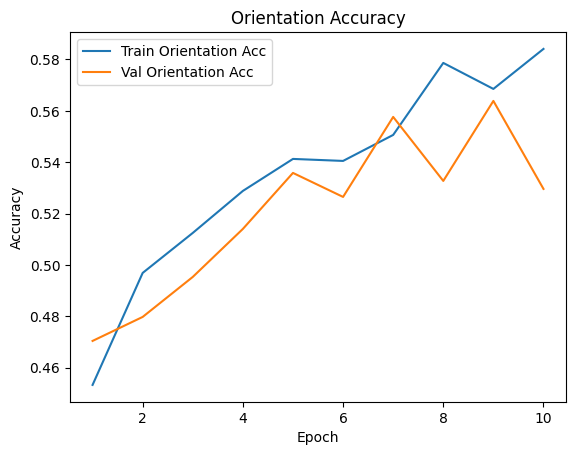

In [6]:
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Total Multi-task Loss (Type + Orientation)")
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, train_acc_type, label="Train Type Acc")
plt.plot(epochs, val_acc_type, label="Val Type Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Type Accuracy")
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, train_acc_orientation, label="Train Orientation Acc")
plt.plot(epochs, val_acc_orientation, label="Val Orientation Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Orientation Accuracy")
plt.legend()
plt.show()


In [7]:
print("Final validation accuracy:")
print("Type       :", val_acc_type[-1])
print("Orientation:", val_acc_orientation[-1])

print("\nDataset label arrays:")
print("type_labels_np shape   :", type_labels_np.shape)
print("orient_labels_np shape :", orient_labels_np.shape)

print("\nValidation NumPy label/pred arrays (last epoch):")
print("y_true_type_val shape   :", y_true_type_val.shape)
print("y_pred_type_val shape   :", y_pred_type_val.shape)
print("y_true_orient_val shape :", y_true_orient_val.shape)
print("y_pred_orient_val shape :", y_pred_orient_val.shape)


Final validation accuracy:
Type       : 0.4984423676012461
Orientation: 0.5295950155763239

Dataset label arrays:
type_labels_np shape   : (1605,)
orient_labels_np shape : (1605,)

Validation NumPy label/pred arrays (last epoch):
y_true_type_val shape   : (321,)
y_pred_type_val shape   : (321,)
y_true_orient_val shape : (321,)
y_pred_orient_val shape : (321,)


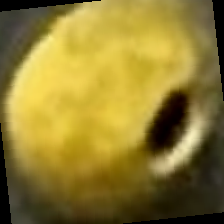

True Type:        Jib | Predicted: Jib
True Orientation: Up | Predicted: Up
------------------------------------------------------------


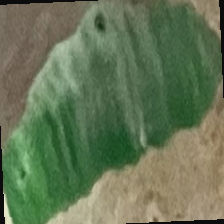

True Type:        Pinch | Predicted: Jug
True Orientation: Up | Predicted: UpAng
------------------------------------------------------------


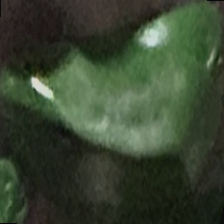

True Type:        Jug | Predicted: Jib
True Orientation: Up | Predicted: Up
------------------------------------------------------------


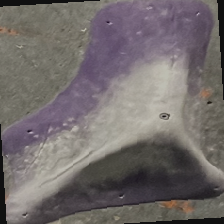

True Type:        Pinch | Predicted: Pinch
True Orientation: Side | Predicted: UpAng
------------------------------------------------------------


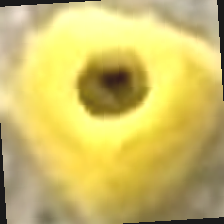

True Type:        Jib | Predicted: Jib
True Orientation: Up | Predicted: Up
------------------------------------------------------------


In [8]:
import random

def show_predictions(n=5):
    model.eval()
    for _ in range(n):
        idx = random.randint(0, len(val_dataset) - 1)
        sample = val_dataset[idx]

        img = sample["image"].unsqueeze(0).to(device)

        with torch.no_grad():
            out_type, out_orient = model(img)

        pred_type = out_type.argmax(1).item()
        pred_orient = out_orient.argmax(1).item()

        true_type = sample["type"]
        true_orient = sample["orientation"]

        type_name_true = dataset.types_list[true_type]
        type_name_pred = dataset.types_list[pred_type]

        orient_name_true = dataset.orientations_list[true_orient]
        orient_name_pred = dataset.orientations_list[pred_orient]

        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        denorm_img = sample["image"] * std + mean
        denorm_img = denorm_img.clamp(0, 1)

        img_pil = transforms.ToPILImage()(denorm_img.cpu())

        display(img_pil)
        print(f"True Type:        {type_name_true} | Predicted: {type_name_pred}")
        print(f"True Orientation: {orient_name_true} | Predicted: {orient_name_pred}")
        print("-" * 60)

show_predictions(5)
